In [48]:
##########fetching preprocessed train and test data 
%store -r X_train
%store -r y_train
%store -r X_test

In [2]:
X_train.shape, X_test.shape

((1460, 216), (1459, 216))

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
from __future__ import print_function
import sys
%matplotlib inline
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas import Series, DataFrame
from time import time
sns.set()
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.metrics import r2_score, make_scorer, mean_squared_error 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
from sklearn.metrics import r2_score, make_scorer,mean_squared_error

#### Splitting data into train and validation

In [49]:
X_train, X_valid, y_train, y_valid =train_test_split(X_train,y_train,test_size=0.4, \
                                                     random_state=123)

### Model customizing with Gridsearch

In [7]:
def custom_model(my_parameters,model_name,X_train,y_train,X_valid,y_valid):
    
    my_score = make_scorer(r2_score,greater_is_better=True)
    model = GridSearchCV(model_name, my_parameters, cv=10,scoring = my_score)

    model.fit(X_train, y_train)

    print("Best parameters set:",model.best_params_)
    print()
    print("Grid scores on every set of parameters:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.04f) for %r" % (mean, std * 2, params))
 
    print()
    y_pred = model.predict(X_valid)
    r2 = r2_score(y_valid, y_pred)
    mse = mean_squared_error(y_valid, y_pred)
    print("R2 score:",r2,"Mean square error:", mse)
    %time
    return model.best_estimator_

# Model fitting

I have fitted Lasso, Elasticnet, Randomforest and xgboost regressor without reducing dimension.

## 1. Gridsearch cross validation using Lasso model

In [18]:
my_parameters = {'alpha':[0.005, 0.01,1], 'normalize':[True,False],\
                'max_iter':[50000,60000,80000]}
model_name=Lasso()

lasso_estimators=custom_model(my_parameters,model_name,X_train,y_train,X_valid,y_valid)

Best parameters set: {'alpha': 0.005, 'max_iter': 50000, 'normalize': False}

Grid scores on every set of parameters:

0.743 (+/-0.0486) for {'alpha': 0.005, 'max_iter': 50000, 'normalize': True}
0.906 (+/-0.0393) for {'alpha': 0.005, 'max_iter': 50000, 'normalize': False}
0.743 (+/-0.0486) for {'alpha': 0.005, 'max_iter': 60000, 'normalize': True}
0.906 (+/-0.0393) for {'alpha': 0.005, 'max_iter': 60000, 'normalize': False}
0.743 (+/-0.0486) for {'alpha': 0.005, 'max_iter': 80000, 'normalize': True}
0.906 (+/-0.0393) for {'alpha': 0.005, 'max_iter': 80000, 'normalize': False}
0.439 (+/-0.0661) for {'alpha': 0.01, 'max_iter': 50000, 'normalize': True}
0.900 (+/-0.0420) for {'alpha': 0.01, 'max_iter': 50000, 'normalize': False}
0.439 (+/-0.0661) for {'alpha': 0.01, 'max_iter': 60000, 'normalize': True}
0.900 (+/-0.0420) for {'alpha': 0.01, 'max_iter': 60000, 'normalize': False}
0.439 (+/-0.0661) for {'alpha': 0.01, 'max_iter': 80000, 'normalize': True}
0.900 (+/-0.0420) for {'alpha': 0.

Text(0.5,1,'feature importance from Lasso regression')

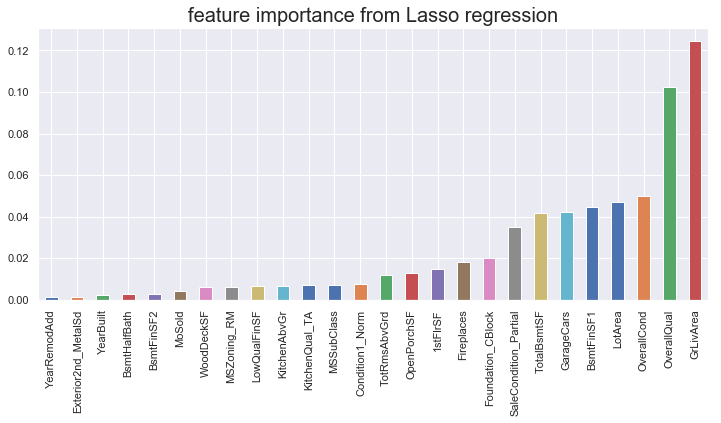

In [19]:
predictors=X_train.columns
plt.figure(figsize=(12,5))
coef=Series(abs(lasso_estimators.coef_),predictors).sort_values()[190:]
coef.plot(kind="bar")
plt.title("feature importance from Lasso regression",fontsize=20)

#### Lasso predicted important features

In [20]:
coef[::-1][:5].index

Index(['GrLivArea', 'OverallQual', 'OverallCond', 'LotArea', 'BsmtFinSF1'], dtype='object')

## 2. RandomForest Regression

In [22]:
my_parameters = {"max_depth": [None],"n_estimators":[100,250,300,400]}

model_name=RandomForestRegressor(random_state=42)

rf_estimators=custom_model(my_parameters,model_name,X_train,y_train,X_valid,y_valid)

Best parameters set: {'max_depth': None, 'n_estimators': 400}

Grid scores on every set of parameters:

0.863 (+/-0.0715) for {'max_depth': None, 'n_estimators': 100}
0.863 (+/-0.0743) for {'max_depth': None, 'n_estimators': 250}
0.864 (+/-0.0734) for {'max_depth': None, 'n_estimators': 300}
0.864 (+/-0.0735) for {'max_depth': None, 'n_estimators': 400}

R2 score: 0.8427527097977563 Mean square error: 0.026700730633707977
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


Text(0.5,1,'feature importance from RF regression')

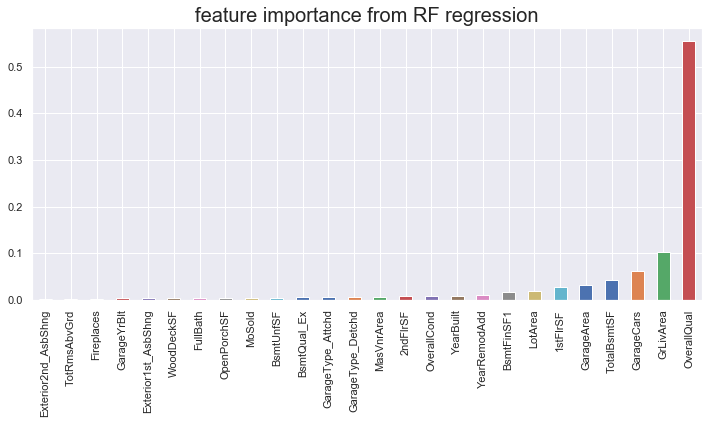

In [23]:
predictors=X_train.columns
plt.figure(figsize=(12,5))
coef=Series(abs(rf_estimators.feature_importances_),predictors).sort_values()[190:]
coef.plot(kind="bar")
plt.title("feature importance from RF regression",fontsize=20)

#### RF predicted important features

In [24]:
coef[::-1][:5].index

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'GarageArea'], dtype='object')

## 3. ElasticNet

In [29]:
my_parameters = {'alpha':[0.005,0.008, 0.01, 0.05, 1],\
                 'normalize':[True,False],\
                'l1_ratio':[0.5, 0.7, 0.9, 0.95, 0.99, 1]}

model_name=ElasticNet(random_state=123)

elnet_estimators=custom_model(my_parameters,model_name,X_train,y_train,X_valid,y_valid)


Best parameters set: {'alpha': 0.005, 'l1_ratio': 0.5, 'normalize': False}

Grid scores on every set of parameters:

0.784 (+/-0.0304) for {'alpha': 0.005, 'l1_ratio': 0.5, 'normalize': True}
0.914 (+/-0.0343) for {'alpha': 0.005, 'l1_ratio': 0.5, 'normalize': False}
0.757 (+/-0.0280) for {'alpha': 0.005, 'l1_ratio': 0.7, 'normalize': True}
0.910 (+/-0.0373) for {'alpha': 0.005, 'l1_ratio': 0.7, 'normalize': False}
0.742 (+/-0.0351) for {'alpha': 0.005, 'l1_ratio': 0.9, 'normalize': True}
0.908 (+/-0.0390) for {'alpha': 0.005, 'l1_ratio': 0.9, 'normalize': False}
0.741 (+/-0.0394) for {'alpha': 0.005, 'l1_ratio': 0.95, 'normalize': True}
0.907 (+/-0.0392) for {'alpha': 0.005, 'l1_ratio': 0.95, 'normalize': False}
0.742 (+/-0.0460) for {'alpha': 0.005, 'l1_ratio': 0.99, 'normalize': True}
0.906 (+/-0.0393) for {'alpha': 0.005, 'l1_ratio': 0.99, 'normalize': False}
0.743 (+/-0.0486) for {'alpha': 0.005, 'l1_ratio': 1, 'normalize': True}
0.906 (+/-0.0393) for {'alpha': 0.005, 'l1_ratio': 

Text(0.5,1,'feature importance from Elastic regression')

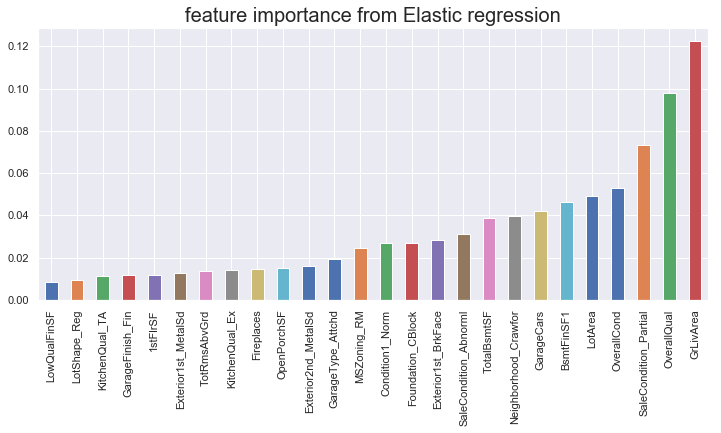

In [30]:
predictors=X_train.columns
plt.figure(figsize=(12,5))
coef=Series(abs(elnet_estimators.coef_),predictors).sort_values()[190:]
coef.plot(kind="bar")
plt.title("feature importance from Elastic regression",fontsize=20)

#### Elasticnet predicted important features

In [31]:
coef[::-1][:5].index

Index(['GrLivArea', 'OverallQual', 'SaleCondition_Partial', 'OverallCond',
       'LotArea'],
      dtype='object')

## 4. XGboost

In [32]:
import xgboost as xgb
my_parameters = {' max_depth':[2,5],\
                 'learning_rate':[0.05,.1,.5], 
                'n_estimators':[5000,7000]}

my_score = make_scorer(r2_score,greater_is_better=True)
model = GridSearchCV(xgb.XGBRegressor(n_jobs =4), my_parameters, cv=2,scoring = my_score)

model.fit(X_train, y_train)

print("Best parameters set:",model.best_params_)
print()
print("Grid scores on every set of parameters:")
print()
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("%0.3f (+/-%0.04f) for %r"
              % (mean, std * 2, params))
 
print()
y_pred = model.predict(X_valid)
r2 = r2_score(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
print("R2 score:",r2,"Mean square error:", mse)
%time



Best parameters set: {' max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 5000}

Grid scores on every set of parameters:

0.883 (+/-0.0140) for {' max_depth': 2, 'learning_rate': 0.05, 'n_estimators': 5000}
0.883 (+/-0.0140) for {' max_depth': 2, 'learning_rate': 0.05, 'n_estimators': 7000}
0.884 (+/-0.0074) for {' max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 5000}
0.884 (+/-0.0074) for {' max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 7000}
0.819 (+/-0.0297) for {' max_depth': 2, 'learning_rate': 0.5, 'n_estimators': 5000}
0.819 (+/-0.0297) for {' max_depth': 2, 'learning_rate': 0.5, 'n_estimators': 7000}
0.883 (+/-0.0140) for {' max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 5000}
0.883 (+/-0.0140) for {' max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 7000}
0.884 (+/-0.0074) for {' max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 5000}
0.884 (+/-0.0074) for {' max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 7000}
0.819 (+/-0.0297) for {' max_de

Text(0.5,1,'feature importance from Elastic regression')

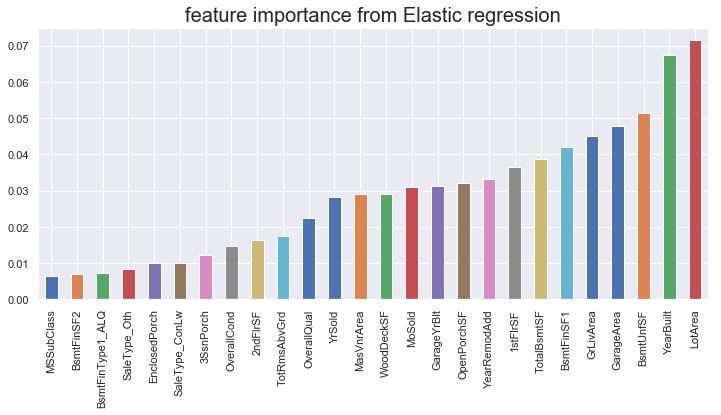

In [34]:
predictors=X_train.columns
plt.figure(figsize=(12,5))
coef=Series(abs(model.best_estimator_.feature_importances_),predictors).sort_values()[190:]
coef.plot(kind="bar")
plt.title("feature importance from Elastic regression",fontsize=20)

#### Xgboost predicted important features

In [35]:
coef[::-1][:5].index

Index(['LotArea', 'YearBuilt', 'BsmtUnfSF', 'GarageArea', 'GrLivArea'], dtype='object')

The best performance is obtained using Xgboost. 
R2 score: 0.856